# Model topology 01: introduction to model topology with `gempy`

Small intro to model topology - on the basis of the simple faulted layer example

In [1]:
import gempy as gp
from gempy.assets import topology as tp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\ProgramData\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Initial gempy model

In [2]:
geo_model = gp.create_model('topology_example')
geo_model = gp.init_data(geo_model, extent = [0, 1000, 0, 1000, 0, 1000], resolution = [30,30,30],
                        path_o = 'modeling_data/or_prior_simpler.csv',
                        path_i = 'modeling_data/surf_prior_simpler.csv')

gp.map_stack_to_surfaces(geo_model, 
                        {'fault' : ['fault'],
                        'layers' : ['rock1', 'rock2']})

geo_model.set_is_fault(['fault'])

geo_model.surfaces.colors.change_colors({'rock1': '#a1d99b',
                                        'rock2' : '#3182bd',
                                        'basement' : '#d9d9d9'})


interp_data = gp.set_interpolator(geo_model,
                                 compile_theano=True,
                                 theano_optimizer='fast_run', gradient=False,
                                 dype='float32')
gp.compute_model(geo_model)

gp.plot_3d(geo_model)

Active grids: ['regular']
Fault colors changed. If you do not like this behavior, set change_color to False.
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!
Kriging values: 
                        values
range             1732.050808
$C_o$            71428.571429
drift equations     [3, 3, 3]


### Topology of initial model

The topology of the initial model can directly be generated with methods from the `gempy.assets` module `topology` (see import above: `from gempy.assets import topology as tp`):

In [3]:
edges, centroids = tp.compute_topology(geo_model)

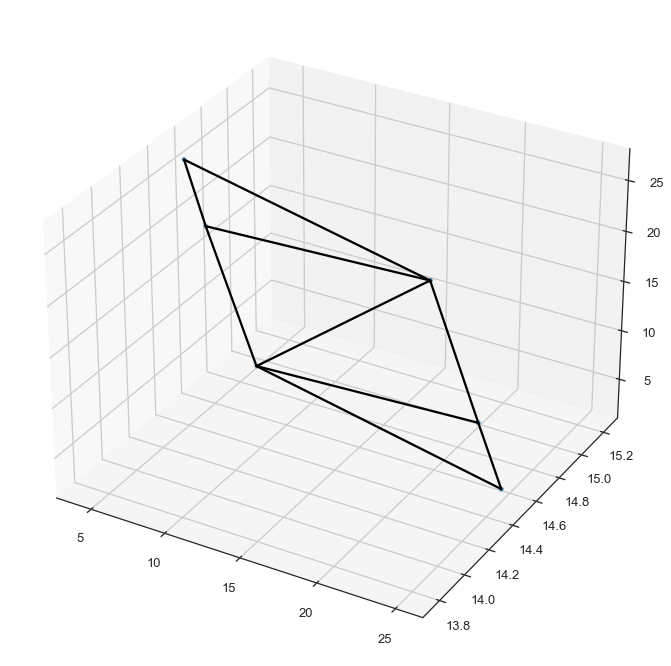

In [13]:
node_indices = []
x,y,z = [],[],[]
for key,coordinates in centroids.items():
    x.append(coordinates[0])
    y.append(coordinates[1])
    z.append(coordinates[2])
    node_indices.append(key)
    
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z)


for k in edges:
    first_node = k[0]
    second_node = k[1]
    i_1 = node_indices.index(first_node)
    i_2 = node_indices.index(second_node)
    ax.plot([x[i_1],x[i_2] ] , [y[i_1],y[i_2]], [z[i_1], z[i_2]], color="black")

A plot of the topology network is also directly possible:

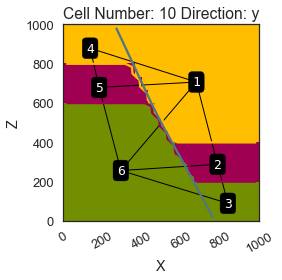

In [5]:
gp.plot_2d(geo_model, show_data = False, direction = 'y', cell_number = 10)
gp.plot.plot_topology(geo_model, edges, centroids, scale=True)
plt.show()

Another (dual) representation of the topology is the representation in an adjacency matrix. This matrix can be calculated with:

In [5]:
adj_matrix_1

array([[0, 1, 0, 1, 1, 1],
       [1, 0, 1, 0, 0, 1],
       [0, 1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1, 0],
       [1, 0, 0, 1, 0, 1],
       [1, 1, 1, 0, 1, 0]], dtype=int8)

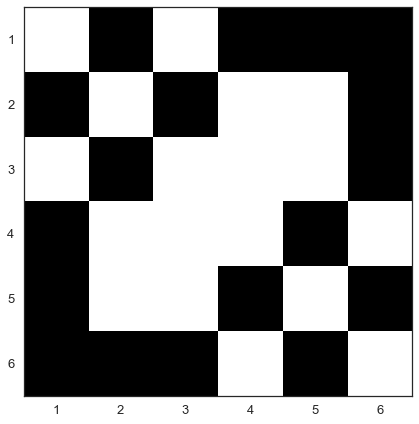

In [4]:
adj_matrix_1 = tp.get_adjacency_matrix(geo_model, edges, centroids).astype(np.int8)

fig, ax = plt.subplots(1,1)
ax.imshow(adj_matrix_1)
ax.set_xticks(np.arange(6))
ax.set_xticklabels(np.arange(1,7))
ax.set_yticks(np.arange(6))
ax.set_yticklabels(np.arange(1,7));

In [9]:
tp.get_adjacency_matrix??

In [14]:
tp.get_lith_ids(geo_model)

[2, 3, 4]

surface
fault       #527682
rock2       #3182bd
rock1       #a1d99b
basement    #d9d9d9
Name: color, dtype: object


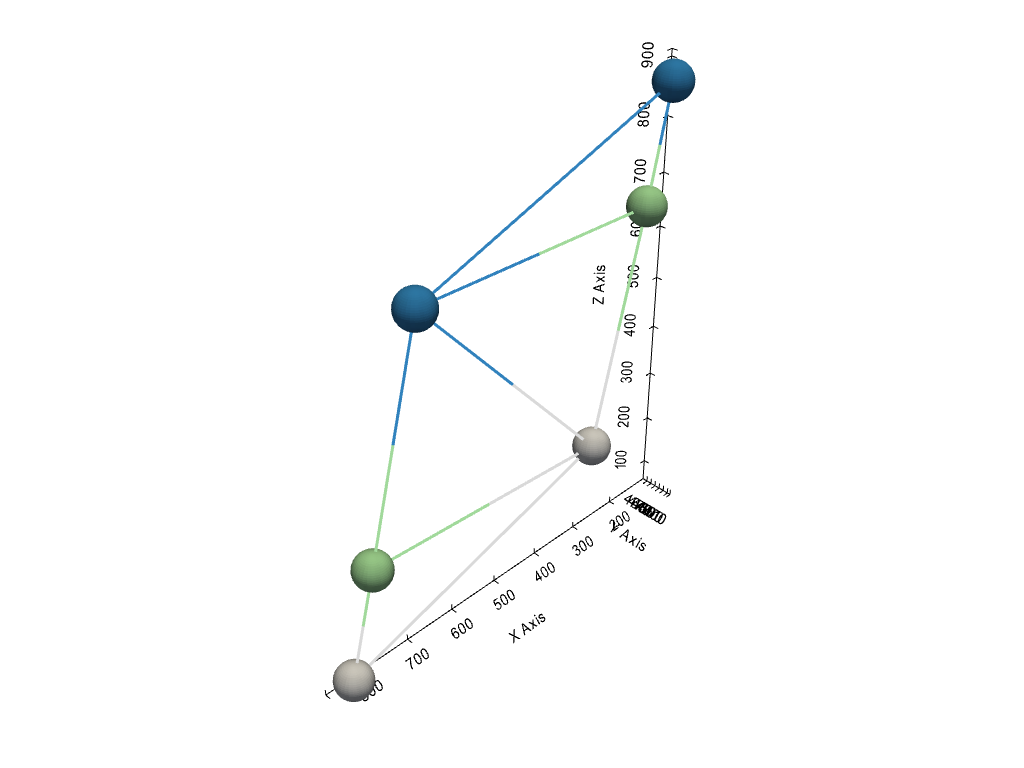

In [16]:
from gempy.plot._vista import Vista
gpv = Vista(geo_model)
gpv.plot_topology(edges, centroids)
gpv.show()

This matrix shows the same information as the graph network above. For example, volume 2 is connected to 1, 3 and 6.